In [ ]:
import random
from math import exp, log, sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Simulating value of covered-call portfolio over specific periods

In [ ]:
def get_data(ticker, periods='1y', rename=None, only_price=False):
  """
  ticker : Object of yf.Ticker
  periods : Data periods
  rename : List of new column names are required if renaming is necessary
  only_price :Getting only price data if other data is not essential
  """
  columns = ['Close'] if only_price == True else ['Close','Volume']
  ticker_hist = ticker.history(period=periods)
  ticker_hist = ticker_hist[columns]
  rename = ['price'] if ((rename == None) and (only_price == True)) else rename
  ticker_hist.columns = rename
  ticker_hist = ticker_hist.reset_index()
  ticker_hist['Date'] = pd.to_datetime(ticker_hist['Date']).dt.strftime('%Y-%m-%d')
  return ticker_hist

In [ ]:
def scaler(df):
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
  return scaled_df

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    call_price = S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    return call_price

In [ ]:
def covered_call_value(start_b, start_s, days, M, s_v, threshold, fee):
  """
  c_prm : Call option premium
  b : Latest portfolio value
  s : Latest spot price
  x : Latest strike price
  b_lst : List of portfolio values
  s_lst : List of spot prices
  x_lst : List of strike prices
  """
  c_prm = black_scholes_call(start_s, start_s*(1.05), days, 0.02, s_v)
  b = (start_b - start_s) + c_prm + start_s
  s = start_s
  x = start_s*(1.05)
  b_lst = []
  s_lst = []
  x_lst = []

  b_lst.append(b)
  s_lst.append(s)
  x_lst.append(x)
  for j in range(M):
    rnd_lst = [random.random() for _ in range(days)]
    print(f"{j} month")
    for i in range(days):
      if rnd_lst[i] >= threshold:
        s = s + (s*s_v)
      else:
        s = s - (s*s_v)
      print(f"day {i} price is {s}")
      # s_lst.append(round(s,4))
    s_lst.append(round(s,4))
    x = round(s+(s*0.05),4) # calculate new strike price of new call option for next 30days
    x_lst.append(x)
    # c_prm = black_scholes_call(s_lst[-1], x_lst[-1], days, 0.02, s_v) # calculate new premium of new call option, whose strike price is updated.
    c_prm = round(5 + max(x_lst[-1] - s_lst[-1], 0),4)
    if s_lst[-1] <= x_lst[j]: # otm
      b = b_lst[j] + (s_lst[-1]-s_lst[j]) + c_prm
      b_lst.append(b)
    else: # itm
      borrow = abs(b_lst[j] - s_lst[-1])
      b = c_prm - borrow
      b_lst.append(b)
    print(f"s : {s_lst[-1]} and x : {x_lst[-1]} and x/s = {round(x_lst[-1]/s_lst[-1],4)} and x-s = {round(x_lst[-1] - s_lst[-1],4)}, c_prm : {c_prm}")
  return (b_lst, s_lst, x_lst)

Simulation down below shows the value of covered-call portfolio. Probability of stock(=spot) price goes down is little bit higher, which means there are merely downward trend in the market.

In [ ]:
# options are assumed only for call option
current_b = 100 # current port value
current_s = 100
s_v = 0.005 # stock price volatility. Unlike real world, it is constant for my simulation.
days = 30 # i assumed there are 30 days per month.
M = 36 # month
pf_value_lst = []
sp_price_lst = []
threshold = 0.51 # controls tendency of stock movement. If threshold is less than 0.5 then, it implies there are more liklihood for stock price move upward.
fee = 0.009
b_lst, s_lst, x_lst = covered_call_value(current_b, current_s, days, M, s_v, threshold,fee)

0 month
day 0 price is 99.5
day 1 price is 99.9975
day 2 price is 99.4975125
day 3 price is 99.0000249375
day 4 price is 98.50502481281251
day 5 price is 98.01249968874845
day 6 price is 97.5224371903047
day 7 price is 98.01004937625622
day 8 price is 97.51999912937494
day 9 price is 98.00759912502181
day 10 price is 98.49763712064693
day 11 price is 98.99012530625016
day 12 price is 98.49517467971891
day 13 price is 98.9876505531175
day 14 price is 99.4825888058831
day 15 price is 98.98517586185368
day 16 price is 98.49024998254441
day 17 price is 98.98270123245713
day 18 price is 98.48778772629484
day 19 price is 97.99534878766336
day 20 price is 97.50537204372505
day 21 price is 97.01784518350642
day 22 price is 97.50293440942396
day 23 price is 97.01541973737683
day 24 price is 97.50049683606372
day 25 price is 97.01299435188339
day 26 price is 97.4980593236428
day 27 price is 97.01056902702459
day 28 price is 96.52551618188946
day 29 price is 97.00814376279891
s : 97.0081 and x : 

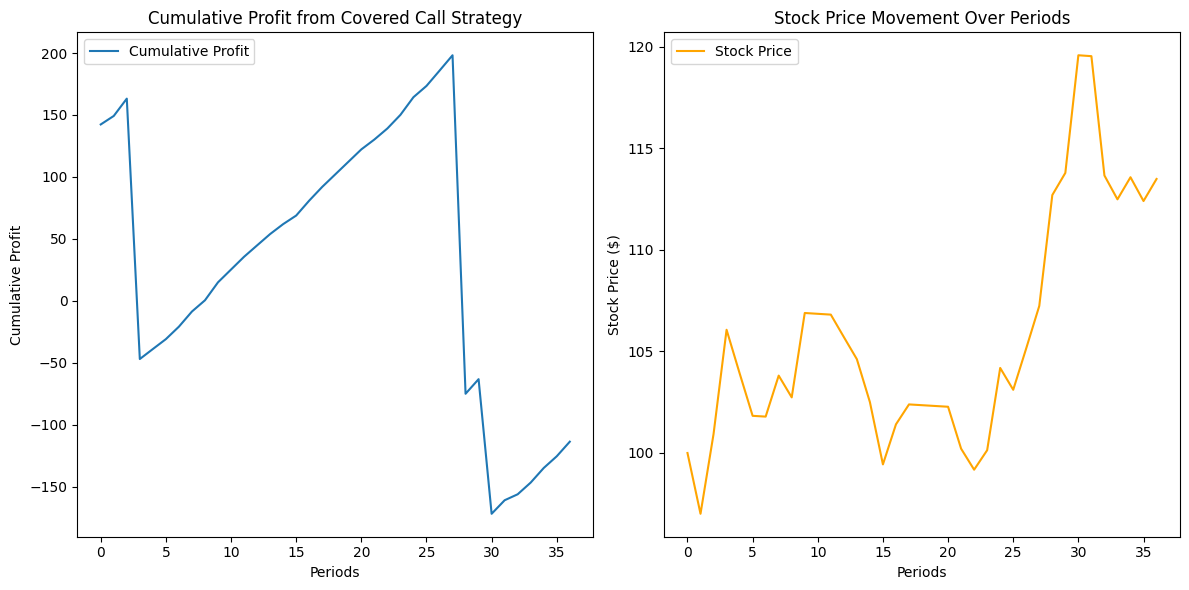

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(range(len(b_lst)), b_lst, label="Cumulative Profit")
plt.xlabel("Periods")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit from Covered Call Strategy")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(range(len(s_lst)), s_lst, label="Stock Price", color="orange")
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

Now, i lowered threshold(which indicates prob. of stock goes up is much higher than previous) and also changed stock price volatility to 0.006(which means price can move 0.6% per day for both directions)

In [ ]:
# options are assumed only for call option
current_b = 100 # current port value
current_s = 100
s_v = 0.006 # stock price volatility. Unlike real world, it is constant for my simulation.
days = 30 # i assumed there are 30 days per month.
M = 36 # month
pf_value_lst = []
sp_price_lst = []
threshold = 0.45 # controls tendency of stock movement. If threshold is less than 0.5 then, it implies there are more liklihood for stock price move upward.
fee = 0.009
b_lst, s_lst, x_lst = covered_call_value(current_b, current_s, days, M, s_v, threshold,fee)

0 month
day 0 price is 99.4
day 1 price is 98.8036
day 2 price is 99.3964216
day 3 price is 99.9928001296
day 4 price is 99.3928433288224
day 5 price is 99.98920038879533
day 6 price is 99.38926518646255
day 7 price is 98.79292959534378
day 8 price is 98.20017201777172
day 9 price is 98.78937304987835
day 10 price is 99.38210928817762
day 11 price is 99.97840194390668
day 12 price is 100.57827235557012
day 13 price is 99.9748027214367
day 14 price is 99.37495390510809
day 15 price is 98.77870418167744
day 16 price is 98.18603195658737
day 17 price is 98.77514814832689
day 18 price is 99.36779903721686
day 19 price is 98.77159224299355
day 20 price is 98.17896268953558
day 21 price is 98.7680364656728
day 22 price is 99.36064468446683
day 23 price is 99.95680855257363
day 24 price is 100.55654940388908
day 25 price is 99.95321010746575
day 26 price is 100.55292936811054
day 27 price is 101.15624694431921
day 28 price is 101.76318442598512
day 29 price is 102.37376353254103
s : 102.3738 

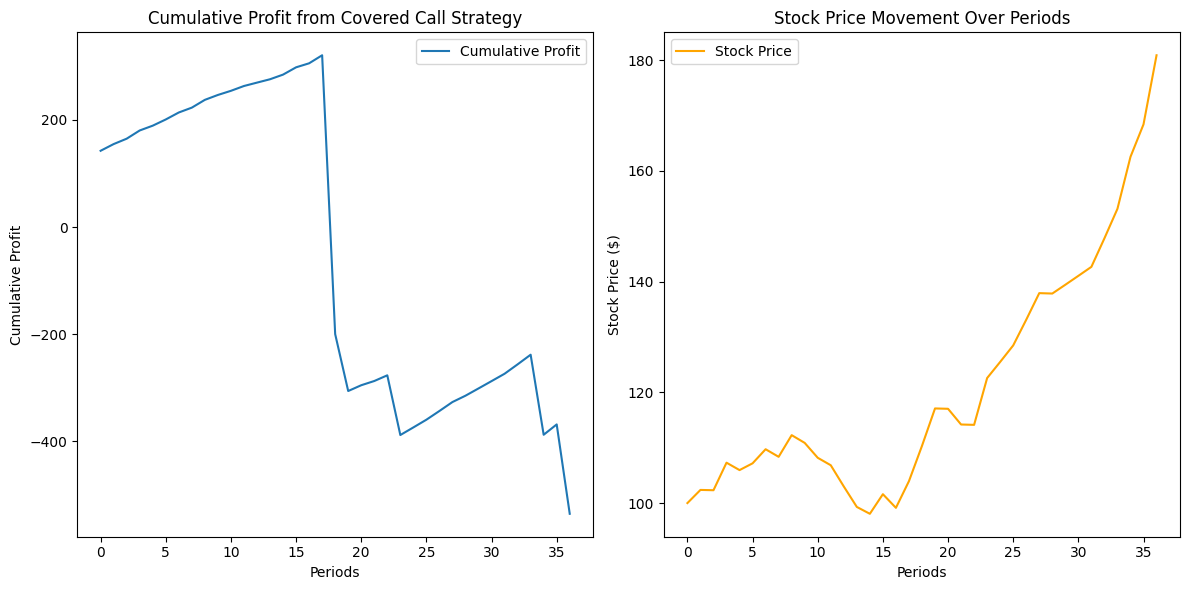

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(range(len(b_lst)), b_lst, label="Cumulative Profit")
plt.xlabel("Periods")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit from Covered Call Strategy")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(range(len(s_lst)), s_lst, label="Stock Price", color="orange")
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

# Movement between CONY ETF and Coinbase stock price and Bitcoin price.

In [ ]:
cony = yf.Ticker("CONY")
coin = yf.Ticker("COIN")
bit = yf.Ticker('BTC-USD')

cony_hist = get_data(cony, rename=['cony_price','cony_volume'])
coin_hist = get_data(coin, rename=['coin_price','coin_volume'])
bit_hist = get_data(bit, rename=['bit_price','bit_volume'])

df_cc = cony_hist.merge(coin_hist, on='Date', how='outer')
df = df_cc.merge(bit_hist, on='Date', how='outer')
df = df.dropna()
df = df.reset_index().drop(columns=['index'])
df

,Date,cony_price,cony_volume,coin_price,coin_volume,bit_price,bit_volume
0,2023-11-09,8.852518,418500.0,92.860001,20941400.0,36693.125000,3.776267e+10
1,2023-11-10,8.884887,416400.0,92.919998,9827900.0,37313.968750,2.271127e+10
2,2023-11-13,8.888931,226900.0,92.639999,8860400.0,36502.355469,1.905771e+10
3,2023-11-14,8.901071,280300.0,92.089996,10137700.0,35537.640625,2.385740e+10
4,2023-11-15,9.257112,354500.0,98.150002,11968900.0,37880.582031,2.736582e+10
...,...,...,...,...,...,...,...
247,2024-11-04,12.710000,2767200.0,186.270004,11348800.0,67811.507812,4.118482e+10
248,2024-11-05,13.080000,1893300.0,193.960007,9950800.0,69359.562500,4.604689e+10
249,2024-11-06,15.910000,7938000.0,254.309998,35456000.0,75639.078125,1.185927e+11
250,2024-11-07,16.120001,4723200.0,255.580002,16655300.0,75904.859375,6.346765e+10


since bitcoin price's unit is different compare to coinbase stock price and cony price, let's normalize each values.

<Axes: >

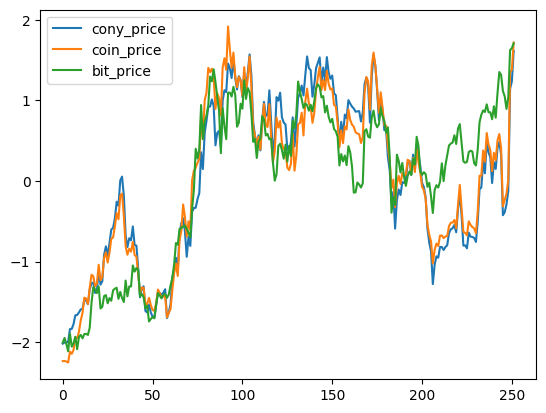

In [ ]:
price_df = df[['cony_price','coin_price','bit_price']]
scaled_price_df = scaler(price_df)
scaled_price_df.plot()

In [ ]:
# let's see correlations
price_df_corr_mat = price_df.corr()
price_df_corr_mat

,cony_price,coin_price,bit_price
cony_price,1.000000,0.979914,0.841131
coin_price,0.979914,1.000000,0.881314
bit_price,0.841131,0.881314,1.000000


# Comparisons of other notable high yield covered call etf TSLY NVDY with their base asset(TSLA NVDA each)

In [ ]:
tsly = yf.Ticker("TSLY")
tsla = yf.Ticker("TSLA")
nvdy = yf.Ticker("NVDY")
nvda = yf.Ticker("NVDA")

tsly_hist = get_data(tsly, periods='6mo', rename=['tsly_price'], only_price=True)
tsla_hist = get_data(tsla, periods='6mo', rename=['tsla_price'], only_price=True)
nvdy_hist = get_data(nvdy, periods='6mo', rename=['nvdy_price'], only_price=True)
nvda_hist = get_data(nvda, periods='6mo', rename=['nvda_price'], only_price=True)

df_ts = tsly_hist.merge(tsla_hist, on='Date', how='outer')
df_nv = nvdy_hist.merge(nvda_hist, on='Date', how='outer')
# df_ts

In [ ]:
scaled_ts_df = scaler(df_ts[['tsly_price','tsla_price']])
scaled_nv_df = scaler(df_nv[['nvdy_price','nvda_price']])

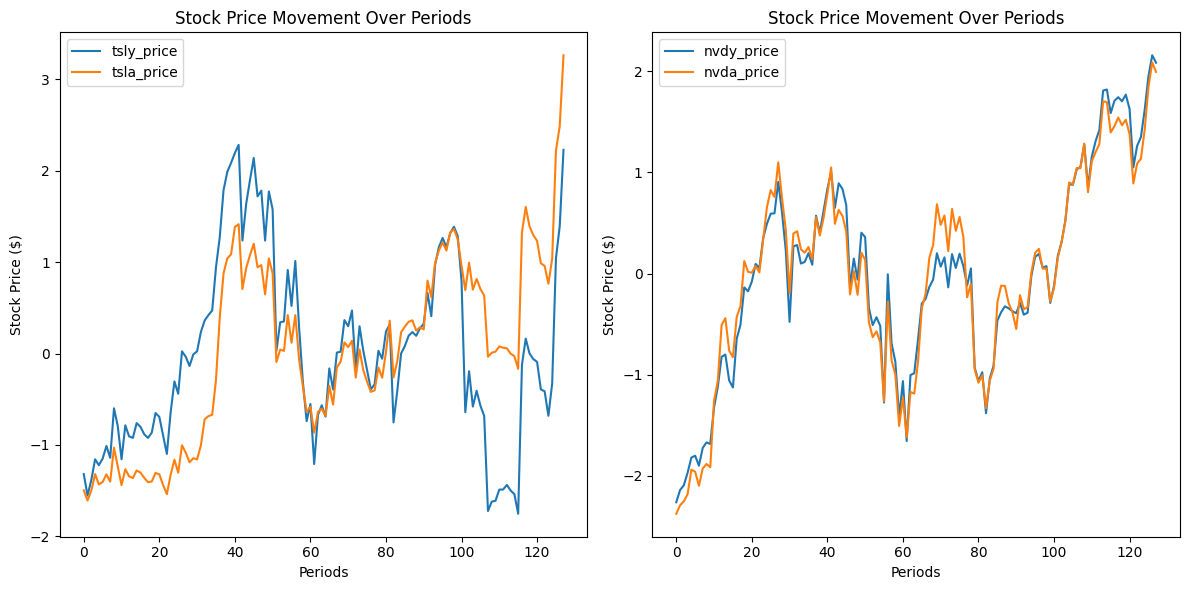

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(scaled_ts_df, label=['tsly_price','tsla_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(scaled_nv_df, label=['nvdy_price','nvda_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_ts_corr_mat = scaled_ts_df.corr()
df_nv_corr_mat = scaled_nv_df.corr()

In [ ]:
df_ts_corr_mat

,tsly_price,tsla_price
tsly_price,1.000000,0.671598
tsla_price,0.671598,1.000000


In [ ]:
df_nv_corr_mat

,nvdy_price,nvda_price
nvdy_price,1.000000,0.983407
nvda_price,0.983407,1.000000
